In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

# Bayesian Optimization
import torch
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.gp_regression import HeteroskedasticSingleTaskGP 
from botorch.utils.transforms import normalize,unnormalize

# Device Set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


# Functions

In [23]:
def scatter_results(data,mean,var,new_x):
    x_values = data
    y_values = mean.numpy().squeeze()
    yvar_values = var.numpy().squeeze()
    # Define the pairs of features to plot
    feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    #lev = np.linspace(0.0,1.0,100)
    # Create contour plots for each pair of features
    plt.figure(figsize=(14, 9))
    for i, (f1, f2) in enumerate(feature_pairs):
        # Extract the pair of features
        x_pair = x_values[:, [f1, f2]].numpy()
        x_new = new_x[:, [f1, f2]]#.numpy()
        
        # Plot the contour plot
        plt.subplot(2, 3, i + 1)
        plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values, cmap='viridis',marker = "h", alpha = 0.5, s=1100)
        plt.scatter(x_new[:,0,],x_new[:,1] , marker = "*", alpha = 0.5, s=100)
        #plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values+yvar_values, cmap='coolwarm',marker = "s", alpha = 0.7, s=100)
        #plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values-yvar_values, cmap='coolwarm',marker = "s", alpha = 0.7, s=100)
        #plt.scatter(x, y, c = zvar, cmap='viridis',marker = "s",alpha = 1, s=6)
        # plt.scatter(x, y, c = z-zvar, cmap='viridis',marker = "s",alpha = 0.5, s=3)
        #plt.scatter(xt_pair[:,0],xt_pair[:,1],color = 'k',marker="*")
        #plt.scatter(x, y, c = z-zvar, cmap='viridis',alpha = 0.3)
        plt.colorbar(label='Output')
        plt.xlabel(f'Feature {f1+1}')
        plt.ylabel(f'Feature {f2+1}')
        plt.title(f'Contour Plot: Feature {f1+1} vs Feature {f2+1}')

    plt.suptitle('Contour Plots for mean')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [24]:
def contour_combination(x_train,data,mean,var,title):
    x_values = data
    y_values = mean.numpy().squeeze()
    yvar_values = var.numpy().squeeze()

    lev = 10#np.linspace(0.5,1.0,20)
    # Interpolate between points
    n = 500j
    # Define the pairs of features to plot
    feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    #lev = np.linspace(0.0,1.0,100)
    # Create contour plots for each pair of features
    plt.figure(figsize=(14, 9))
    for i, (f1, f2) in enumerate(feature_pairs):
        # Extract the pair of features
        xt_pair = x_train[:, [f1, f2]].numpy()
        x_pair = x_values[:, [f1, f2]].numpy()

        # Interpolate the data onto a regular grid
        grid_x, grid_y = np.mgrid[min(x_pair[:,0]):max(x_pair[:,0]):n, min(x_pair[:,1]):max(x_pair[:,1]):n] #np.meshgrid(x1.sort(),x2.sort())

        # Interpolate the mean and variance
        grid_mean = griddata((x_pair[:,0], x_pair[:,1]), y_values, (grid_x, grid_y), method='linear')
        grid_variance = griddata((x_pair[:,0], x_pair[:,1]), yvar_values, (grid_x, grid_y), method='linear')

        # Plot the contour plot
        plt.subplot(2, 3, i + 1)
        # Contour plot for the mean
        contour_mean = plt.contourf(grid_x, grid_y, grid_mean, levels=lev, cmap='viridis', alpha=0.8) #plt.contourf(grid_x, grid_y, grid_mean, levels=20, cmap='viridis', alpha=0.8) / plt.contour(grid_x, grid_y, grid_mean, levels=10, colors='white', linestyles='dashed')
        #plt.clabel(contour_mean, fmt='%1.2f', colors='white', fontsize=8)
        plt.colorbar(contour_mean, label='Posterior Mean')

        # Overlay contour lines for the variance
        contour_variance = plt.contour(grid_x, grid_y, grid_variance, levels= 10, colors='white', linestyles='dashed') #plt.contourf(grid_x, grid_y, grid_variance, levels=20, cmap='viridis', alpha=0.8) / plt.contour(grid_x, grid_y, grid_variance, levels=10, colors='white', linestyles='dashed')
        plt.clabel(contour_variance, fmt='%1.2f', colors='white', fontsize=8)
        #plt.colorbar(contour_variance, label='Contour_variance')
        
        plt.scatter(xt_pair[:,0],xt_pair[:,1],color = 'k',marker="*")
        plt.xlabel(f'Feature {f1+1}')
        plt.ylabel(f'Feature {f2+1}')
        plt.title(f'Contour Plot: Feature {f1+1} vs Feature {f2+1}')

    plt.suptitle(title)
    #plt.title('Contour Plot of Posterior Mean with Variance')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [25]:
def grid_split(mean,num_points,A1,B2,C3,D4,title,cmaps):
    mean = mean.reshape(num_points,num_points,num_points,num_points)
    plt.figure(figsize=(14, 12))
    plt.subplot(3,3,1)
    for i in range(num_points):
        plt.contourf(A1[:,:,i,i],B2[:,:,i,i],mean[:,:,i,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("time")
    plt.ylabel("temp")

    plt.subplot(3,3,2)
    for i in range(num_points):
        plt.contourf(A1[:,i,:,i],C3[:,i,:,i],mean[:,i,:,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("time")
    plt.ylabel("sulf")

    plt.subplot(3,3,3)
    for i in range(num_points):
        plt.contourf(A1[:,i,i,:],D4[:,i,i,:],mean[:,i,i,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("time")
    plt.ylabel("anly")

    plt.subplot(3,3,4)
    for i in range(num_points):
        plt.contourf(B2[i,:,:,i],C3[i,:,:,i],mean[i,:,:,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("temp")
    plt.ylabel("sulf")

    plt.subplot(3,3,5)
    for i in range(num_points):
        plt.contourf(B2[i,:,i,:],D4[i,:,i,:],mean[i,:,i,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("temp")
    plt.ylabel("anly")

    plt.subplot(3,3,6)
    for i in range(num_points):
        plt.contourf(C3[i,i,:,:],D4[i,i,:,:],mean[i,i,:,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("sulf")
    plt.ylabel("anly")
    
    plt.suptitle(title)
    plt.tight_layout()

In [27]:
def gpevaluate(model,grid):
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(grid)
    mean = posterior.mean
    var = posterior.variance
    return mean, var

# Output

In [ ]:
data_summary = pd.read_csv('data_out_review.csv')
data_summary.head()

,00_time,00_temp,00_sulf,00_anly,00_yieldproduct,1A_time,1A_temp,1A_sulf,1A_anly,1A_yieldproduct,1B_time,1B_temp,1B_sulf,1B_anly,1B_yieldproduct,1C_time,1C_temp,1C_sulf,1C_anly,1C_yieldproduct
0,49,45,89,84,0.009799,153,104,75,57,0.294038,68,58,85,65,0.404188,132,62,93,90,0.035990
1,49,45,89,84,0.007847,153,104,75,57,0.908395,68,58,85,65,0.218760,132,62,93,90,0.033651
2,49,45,89,84,0.012064,153,104,75,57,0.344077,68,58,85,65,0.217714,132,62,93,90,0.042650
3,87,95,95,97,0.112870,260,104,80,38,0.523446,101,133,85,98,0.566085,144,89,84,57,0.050086
4,87,95,95,97,0.100768,260,104,80,38,0.488845,101,133,85,98,0.485297,144,89,84,57,0.050017


In [30]:
avg_data00 = data_summary.groupby('00_time').mean().reset_index()[['00_time','00_temp','00_sulf','00_anly','00_yieldproduct']].rename(columns = {'00_time':"time",'00_temp':"temp",'00_sulf':"sulf",'00_anly':"anly",'00_yieldproduct':"yield product"})
std_data00 = data_summary.groupby('00_time').std().reset_index()[['00_time','00_temp','00_sulf','00_anly','00_yieldproduct']].rename(columns = {'00_time':"time",'00_temp':"temp",'00_sulf':"sulf",'00_anly':"anly",'00_yieldproduct':"yield product"})

avg_data1A = data_summary.groupby('1A_time').mean().reset_index()[['1A_time','1A_temp','1A_sulf','1A_anly','1A_yieldproduct']].rename(columns = {'1A_time':"time",'1A_temp':"temp",'1A_sulf':"sulf",'1A_anly':"anly",'1A_yieldproduct':"yield product"})
std_data1A = data_summary.groupby('1A_time').std().reset_index()[['1A_time','1A_temp','1A_sulf','1A_anly','1A_yieldproduct']].rename(columns = {'1A_time':"time",'1A_temp':"temp",'1A_sulf':"sulf",'1A_anly':"anly",'1A_yieldproduct':"yield product"})


In [31]:
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device) #torch.stack([torch.zeros(4), 100 * torch.ones(4)])

x0 = torch.tensor([avg_data00['time'].to_numpy(),avg_data00['temp'].to_numpy(),avg_data00['sulf'].to_numpy(),avg_data00['anly'].to_numpy()],dtype=torch.float32).T
x0 = normalize(x0,bounds)
y0 = torch.tensor(avg_data00['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)
yvar0 = torch.tensor(std_data00['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)

x1 = torch.tensor([avg_data1A['time'].to_numpy(),avg_data1A['temp'].to_numpy(),avg_data1A['sulf'].to_numpy(),avg_data1A['anly'].to_numpy()],dtype=torch.float32).T
x1 = normalize(x1,bounds)
y1 = torch.tensor(avg_data1A['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)
yvar1 = torch.tensor(std_data1A['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)


In [32]:
# Define the ranges for each variable
a_min, a_max = 30, 600 # 30 - 600
b_min, b_max = 20, 170 # 20 - 170
c_min, c_max = 75, 100 # 75 - 100
d_min, d_max = 33, 100 # 33- 100

# Number of points in each dimension
num_points = 15

# Generate linspace for each variable
a = torch.linspace(a_min, a_max, num_points)
b = torch.linspace(b_min, b_max, num_points)
c = torch.linspace(c_min, c_max, num_points)
d = torch.linspace(d_min, d_max, num_points)
grid_stack = torch.stack([a,b,c,d],dim = -1)

#grid = torch.stack([a, b, c, d], dim=1)
# Create a meshgrid
A1, B2, C3, D4 = torch.meshgrid(a,b,c,d, indexing='ij')

# Flatten the grid to get all combinations
grid = torch.stack([A1.flatten(), B2.flatten(), C3.flatten(), D4.flatten()], dim=-1)
grid = normalize(grid,bounds)
# Print the shape of the grid
print(grid.shape)  # Should be (num_points**4, 4)

torch.Size([50625, 4])


In [33]:
#bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)
bounds = torch.tensor([[0., 0., 0. , 0], [1., 1., 1.,1.]], dtype=dtype, device=device)
#bounds = torch.tensor([[avg_data['time'].min(), avg_data['temp'].min(), avg_data['sulf'].min() , avg_data['analyte'].min()], [avg_data['time'].max(), avg_data['temp'].max(), avg_data['sulf'].max() , avg_data['analyte'].max()]], dtype=dtype, device=device)
#[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]
batch_size = 15 #train_size

# For EI 
best_f = torch.tensor(1.0 ,dtype=dtype) 
# For PV
mc_points = torch.rand(1000, 4)


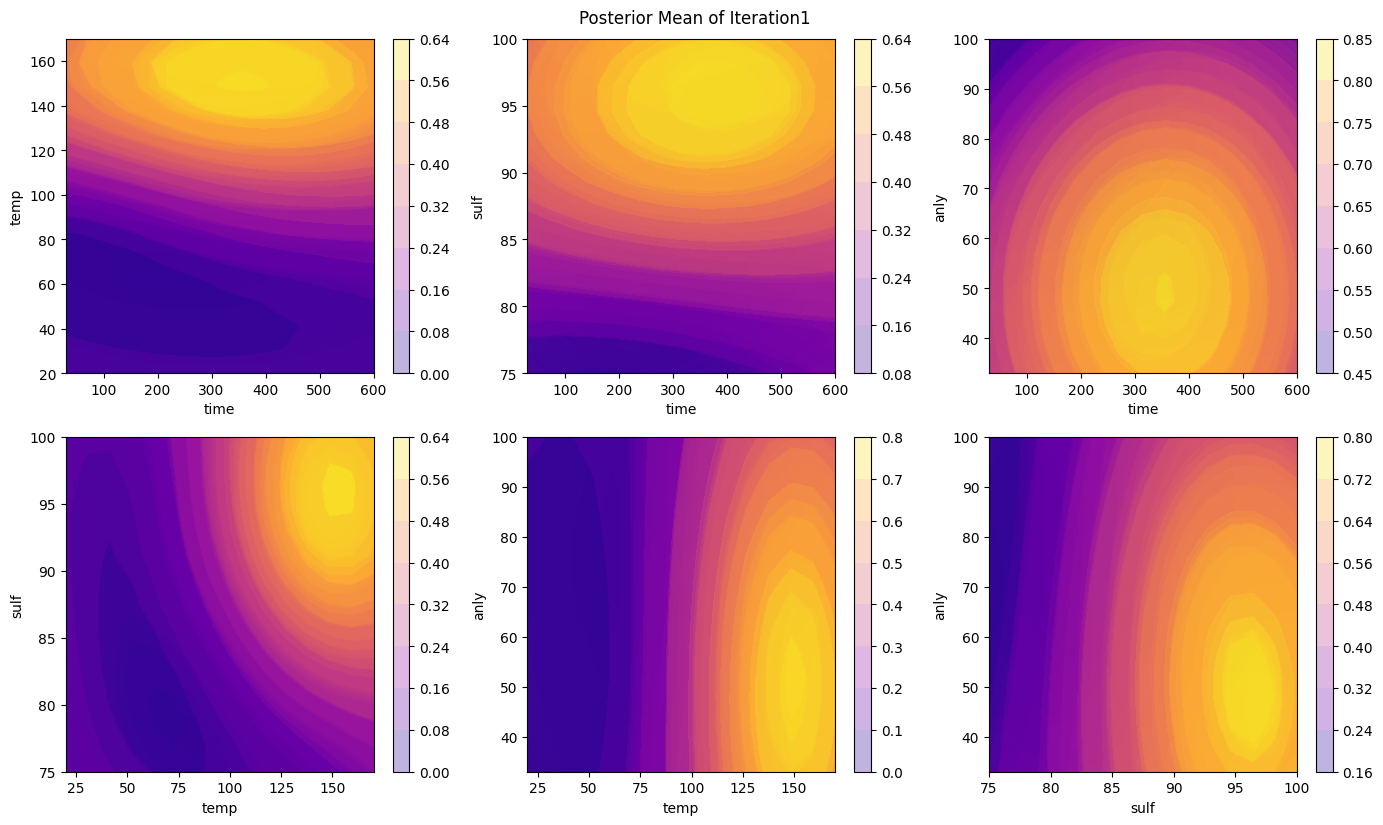

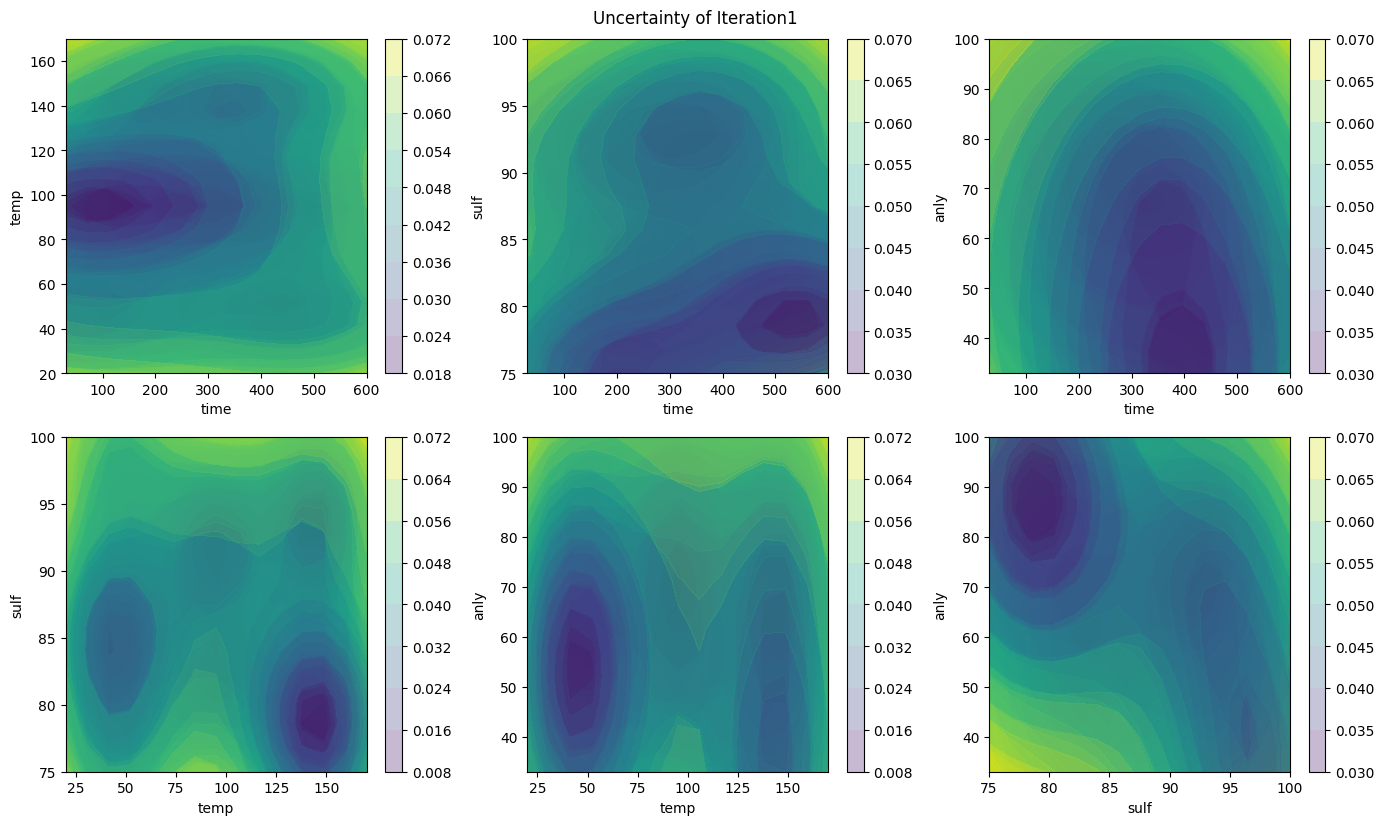

In [35]:
# Iter1
train_x = torch.tensor(torch.vstack([x0]), dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(torch.vstack([y0]), dtype=dtype)
train_yvar = torch.tensor(torch.vstack([yvar0]), dtype=dtype)

## Create the surrogate model
gp_model0 = HeteroskedasticSingleTaskGP(train_x, train_y, train_yvar, outcome_transform=None, input_transform=None) 
mll0 = ExactMarginalLogLikelihood(gp_model0.likelihood, gp_model0)
fit_gpytorch_model(mll0)

mean0,var0 = gpevaluate(gp_model0 ,grid)
grid_split(mean0,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="Posterior Mean of Iteration1",cmaps='plasma')
grid_split(var0,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="Uncertainty of Iteration1",cmaps='viridis')

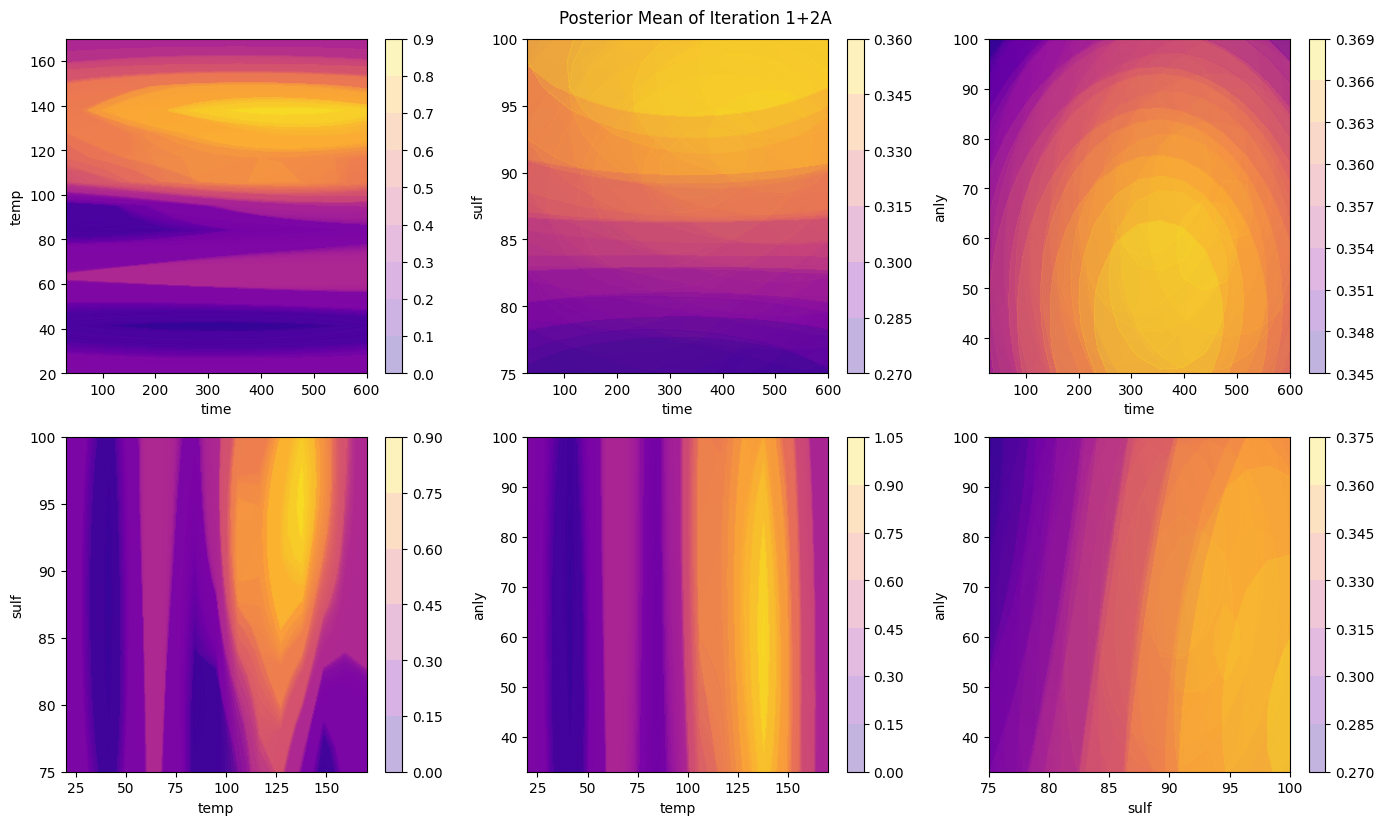

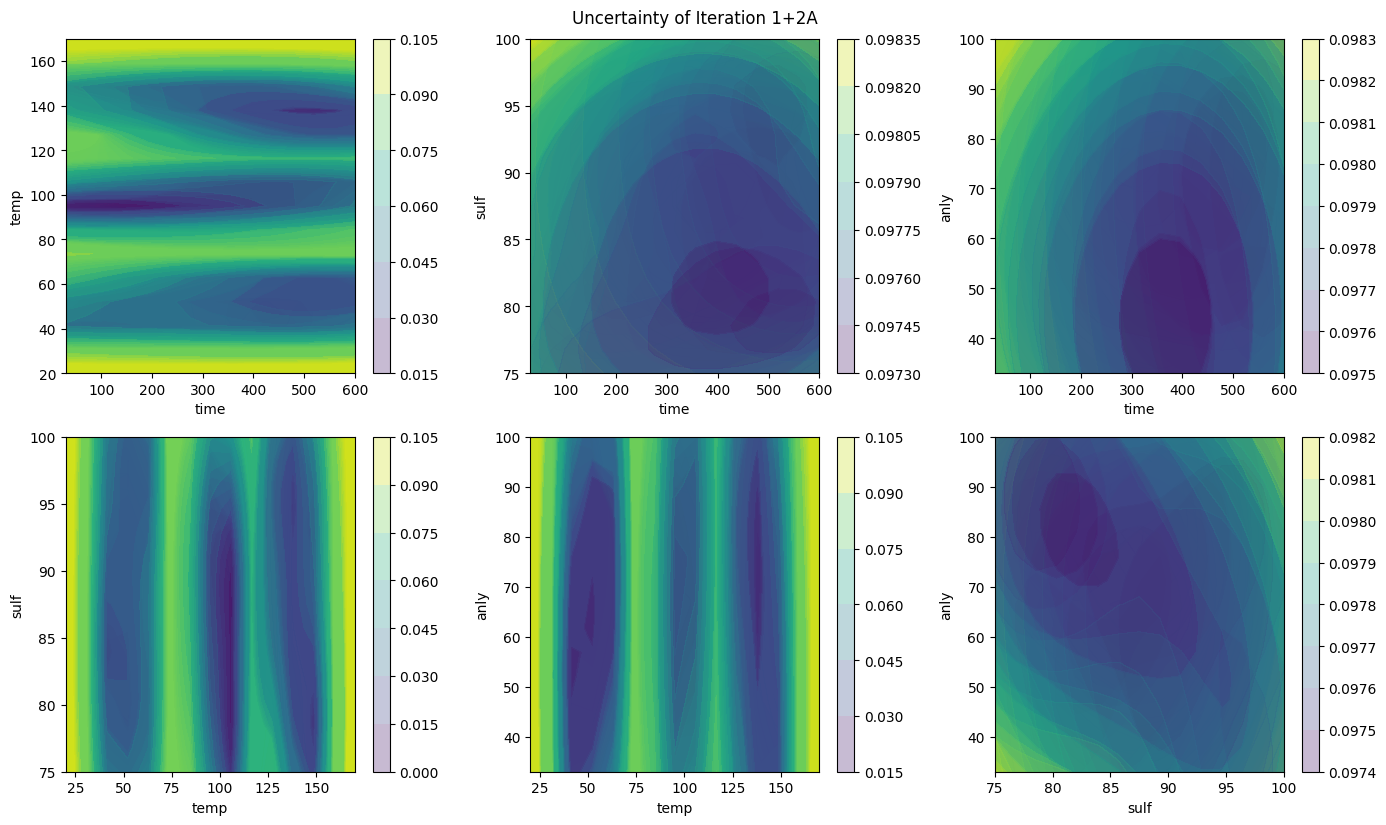

In [36]:
# Combined GP
train_x = torch.tensor(torch.vstack([x0,x1]), dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(torch.vstack([y0,y1]), dtype=dtype)
train_yvar = torch.tensor(torch.vstack([yvar0,yvar1]), dtype=dtype)

## Create the surrogate model
gp_model = HeteroskedasticSingleTaskGP(train_x, train_y, train_yvar, outcome_transform=None, input_transform=None) 
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

mean1,var1 = gpevaluate(gp_model ,grid)
# grid_split(mean1,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="Ground Truth Model")
# grid_variance(mean1,var1,num_points=15,title="Ground Truth Model")
grid_split(mean1,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="Posterior Mean of Iteration 1+2A",cmaps='plasma')
grid_split(var1,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="Uncertainty of Iteration 1+2A",cmaps='viridis')

In [37]:
qEI = qExpectedImprovement(model=gp_model, best_f=best_f)
qUCB = qUpperConfidenceBound(model=gp_model, beta=5) #sampler=SobolQMCNormalSampler(num_samples=15) beta = 0.1
qPV = qNegIntegratedPosteriorVariance(model=gp_model, mc_points = mc_points)

In [38]:
acq_funcs = qEI

candidate, _ = optimize_acqf(
    acq_function=acq_funcs,
    bounds=bounds,
    q=batch_size,
    num_restarts=15,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

candidate



tensor([[1.0000, 0.7903, 0.7506, 0.3701],
        [0.2785, 0.0152, 0.5076, 0.9232],
        [0.6632, 0.7895, 0.7565, 0.3306],
        [0.4462, 0.7993, 0.9826, 0.5077],
        [0.5338, 0.7390, 0.6835, 0.5186],
        [0.9520, 0.8108, 0.9976, 0.4849],
        [0.3349, 0.6328, 0.5221, 0.3547],
        [0.1347, 0.0000, 1.0000, 0.1512],
        [0.5220, 0.7666, 0.8951, 0.0962],
        [1.0000, 0.7149, 0.7032, 0.4537],
        [0.6845, 0.3791, 0.5650, 0.9460],
        [0.6562, 0.6604, 0.7318, 0.7504],
        [0.3493, 0.8602, 1.0000, 0.4031],
        [0.2863, 0.3444, 1.0000, 0.2512],
        [0.1026, 0.5250, 0.2233, 0.7718]])

In [39]:
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)
unnorm_candidate = unnormalize(candidate, bounds)
unnorm_candidate

tensor([[600.0000, 138.5403,  93.7658,  57.7995],
        [188.7504,  22.2811,  87.6892,  94.8555],
        [408.0269, 138.4314,  93.9113,  55.1508],
        [284.3151, 139.9009,  99.5652,  67.0131],
        [334.2378, 130.8555,  92.0874,  67.7430],
        [572.6517, 141.6191,  99.9401,  65.4892],
        [220.9068, 114.9128,  88.0521,  56.7636],
        [106.7602,  20.0000, 100.0000,  43.1308],
        [327.5682, 134.9852,  97.3773,  39.4483],
        [600.0000, 127.2322,  92.5802,  63.3960],
        [420.1368,  76.8575,  89.1256,  96.3819],
        [404.0476, 119.0527,  93.2960,  83.2785],
        [229.1092, 149.0359, 100.0000,  60.0053],
        [193.1843,  71.6617, 100.0000,  49.8325],
        [ 88.4964,  98.7495,  80.5836,  84.7078]])

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

time = unnorm_candidate[:,0]//1
temp = unnorm_candidate[:,1]//1
sulf = unnorm_candidate[:,2]//1
anly = unnorm_candidate[:,3]//1

data = {
    'time': time,
    'temp': temp,
    'sulf': sulf,
    'anly': anly
}
df = pd.DataFrame(data)
df

,time,temp,sulf,anly
0,600.0,138.0,93.0,57.0
1,188.0,22.0,87.0,94.0
2,408.0,138.0,93.0,55.0
3,284.0,139.0,99.0,67.0
4,334.0,130.0,92.0,67.0
5,572.0,141.0,99.0,65.0
6,220.0,114.0,88.0,56.0
7,106.0,20.0,100.0,43.0
8,327.0,134.0,97.0,39.0
9,600.0,127.0,92.0,63.0


Centroids of Temperature Clusters:
[[133.  82.  21.]]


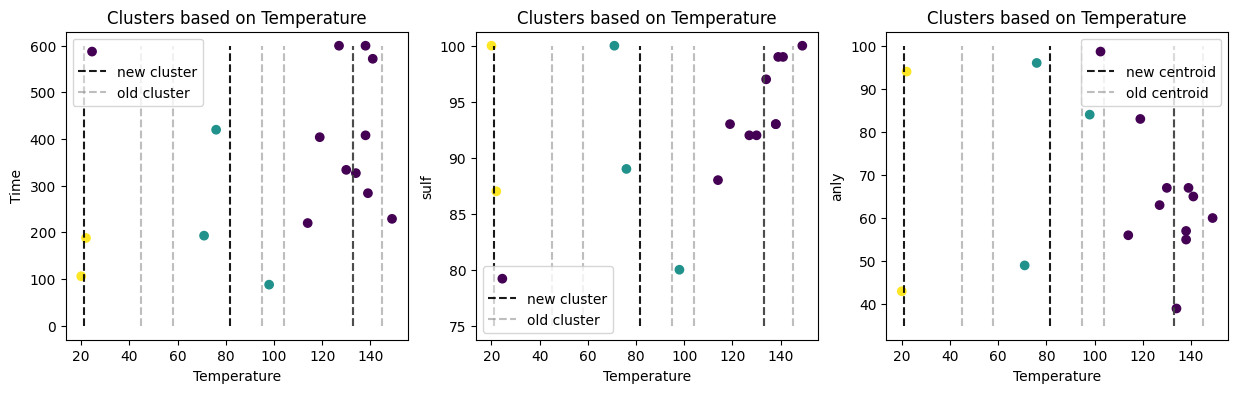

In [41]:
# Select the 'temp' column for clustering
temp_data = df[['temp']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
temp_data_scaled = scaler.fit_transform(temp_data)

# Choose the number of clusters
num_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#kmeans = KMeans(n_clusters=num_clusters, random_state=0)

df['temp_cluster'] = kmeans.fit_predict(temp_data_scaled)
kmeans.fit(temp_data)

# Get the centroids
centroids = kmeans.cluster_centers_
#centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids.round()

# cluster_assignments
# cluster_assignments = kmeans.labels_

# old centroids
old = [45.,145.,95.,104.,58.,133.]

# Display the centroids
print("Centroids of Temperature Clusters:")
print(centroids.round().T)

# Visualize the clusters
fig = plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.scatter(df['temp'], df['time'], c=df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])

plt.subplot(1,3,2)
plt.scatter(df['temp'], df['sulf'], c=df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,75,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,75,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('sulf')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])


plt.subplot(1,3,3)
plt.scatter(df['temp'], df['anly'], c=df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,35,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,35,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('anly')
plt.title('Clusters based on Temperature')
plt.legend(['','new centroid','old centroid'])


plt.show()

In [43]:
#Re-organize table to three temperatures:
# Example usage:
temp1 = centroids[0]
temp2 = centroids[1]
temp3 = centroids[2]


for i in range(len(df)):
  d1 = abs(df.temp[i]-temp1)
  d2 = abs(df.temp[i]-temp2)
  d3 = abs(df.temp[i]-temp3)

  if min(d1,d2,d3) == d1:
    df.temp[i] = temp1.round()
  elif min(d1,d2,d3) == d2:
    df.temp[i] = temp2.round()
  else:
    df.temp[i] = temp3.round()
df#.sort_values('temp')

,time,temp,sulf,anly,temp_cluster
0,600.0,133.0,93.0,57.0,0
1,188.0,21.0,87.0,94.0,2
2,408.0,133.0,93.0,55.0,0
3,284.0,133.0,99.0,67.0,0
4,334.0,133.0,92.0,67.0,0
5,572.0,133.0,99.0,65.0,0
6,220.0,133.0,88.0,56.0,0
7,106.0,21.0,100.0,43.0,2
8,327.0,133.0,97.0,39.0,0
9,600.0,133.0,92.0,63.0,0


In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(dot_prd)

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(unnorm_candidate[:,1].reshape(-1,1))
centroids = kmeans.cluster_centers_
centroids.round()

array([[133.],
       [ 82.],
       [ 21.]])

In [45]:
df_candidate = pd.DataFrame(df)
df_candidate.sort_values('temp')

,time,temp,sulf,anly,temp_cluster
1,188.0,21.0,87.0,94.0,2
7,106.0,21.0,100.0,43.0,2
10,420.0,82.0,89.0,96.0,1
13,193.0,82.0,100.0,49.0,1
14,88.0,82.0,80.0,84.0,1
0,600.0,133.0,93.0,57.0,0
2,408.0,133.0,93.0,55.0,0
3,284.0,133.0,99.0,67.0,0
4,334.0,133.0,92.0,67.0,0
5,572.0,133.0,99.0,65.0,0


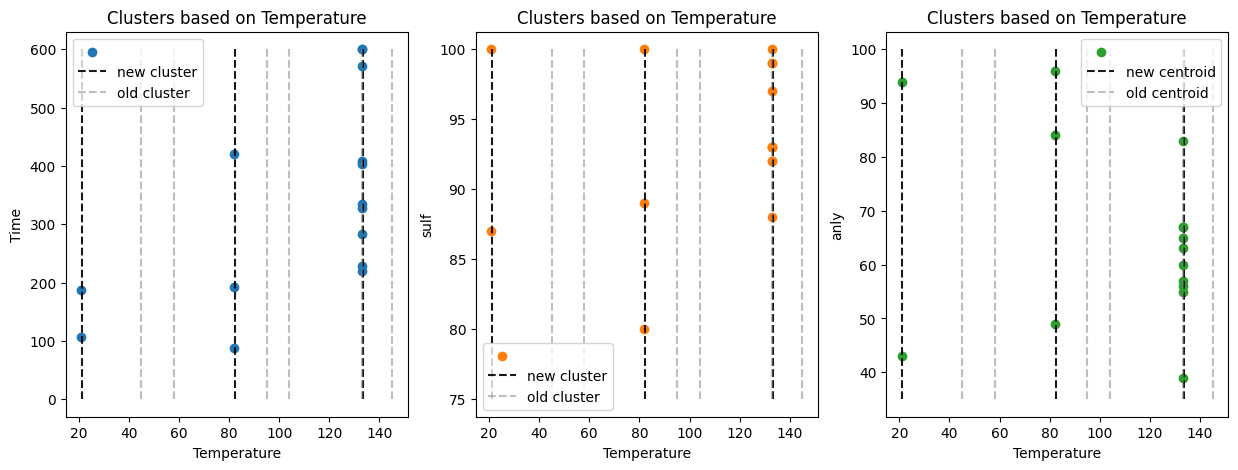

In [46]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df_candidate['temp'], df_candidate['time'], color="tab:blue")
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])

plt.subplot(1,3,2)
plt.scatter(df_candidate['temp'], df_candidate['sulf'],color="tab:orange")
plt.vlines(centroids,75,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,75,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('sulf')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])


plt.subplot(1,3,3)
plt.scatter(df_candidate['temp'], df_candidate['anly'], color="tab:green")
plt.vlines(centroids,35,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,35,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('anly')
plt.title('Clusters based on Temperature')
plt.legend(['','new centroid','old centroid'])

In [47]:
new_x = df_candidate[["time","temp","sulf","anly"]].to_numpy()

In [48]:
def grid_split_new(mean,num_points,A1,B2,C3,D4,title,new_x,cmaps):
    mean = mean.reshape(num_points,num_points,num_points,num_points)
    plt.figure(figsize=(14, 11))
    plt.subplot(3,3,1)
    for i in range(num_points):
        plt.contourf(A1[:,:,i,i],B2[:,:,i,i],mean[:,:,i,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,0],new_x[:,1],marker="*",color = "k")
    plt.xlabel("time")
    plt.ylabel("temp")

    plt.subplot(3,3,2)
    for i in range(num_points):
        plt.contourf(A1[:,i,:,i],C3[:,i,:,i],mean[:,i,:,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,0],new_x[:,2],marker="*",color = "k")
    plt.xlabel("time")
    plt.ylabel("sulf")

    plt.subplot(3,3,3)
    for i in range(num_points):
        plt.contourf(A1[:,i,i,:],D4[:,i,i,:],mean[:,i,i,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,0],new_x[:,3],marker="*",color = "k")
    plt.xlabel("time")
    plt.ylabel("anly")

    plt.subplot(3,3,4)
    for i in range(num_points):
        plt.contourf(B2[i,:,:,i],C3[i,:,:,i],mean[i,:,:,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,1],new_x[:,2],marker="*",color = "k")
    plt.xlabel("temp")
    plt.ylabel("sulf")

    plt.subplot(3,3,5)
    for i in range(num_points):
        plt.contourf(B2[i,:,i,:],D4[i,:,i,:],mean[i,:,i,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,1],new_x[:,3],marker="*",color = "k")
    plt.xlabel("temp")
    plt.ylabel("anly")

    plt.subplot(3,3,6)
    for i in range(num_points):
        plt.contourf(C3[i,i,:,:],D4[i,i,:,:],mean[i,i,:,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,2],new_x[:,3],marker="*",color = "k")
    plt.xlabel("sulf")
    plt.ylabel("anly")
    
    plt.suptitle(title)
    plt.tight_layout()

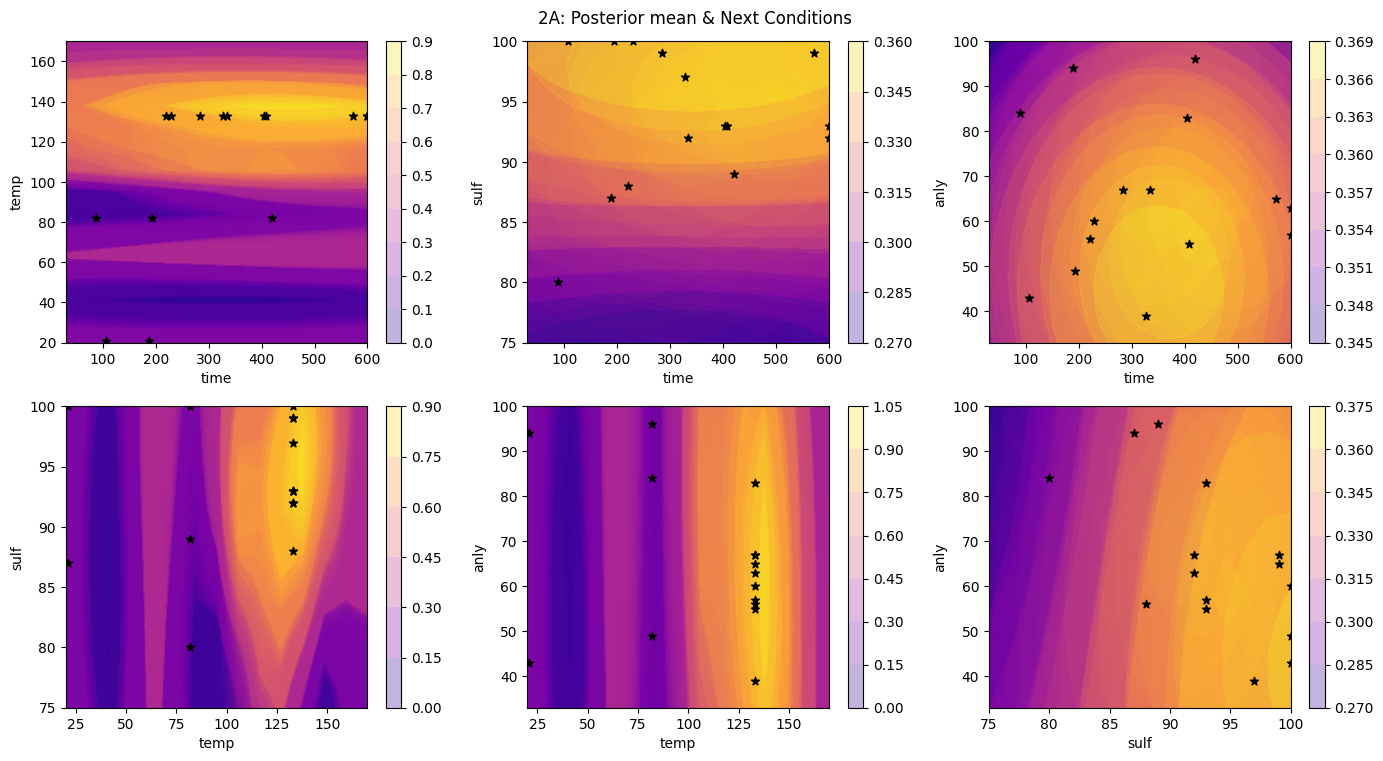

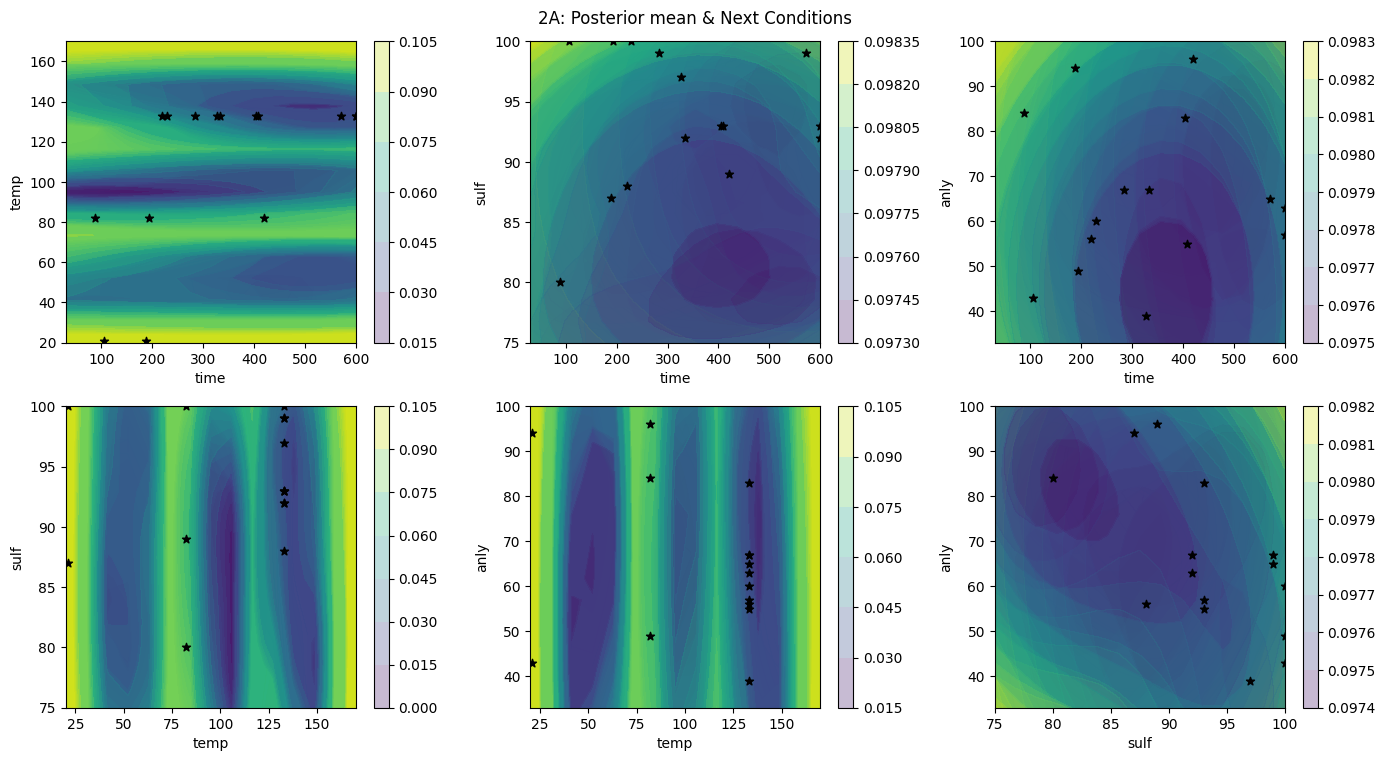

In [49]:
grid_split_new(mean1,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="2A: Posterior mean & Next Conditions",new_x=new_x,cmaps="plasma")
grid_split_new(var1,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="2A: Posterior mean & Next Conditions",new_x=new_x,cmaps="viridis")